# DQN Atari Paper Upgrade using Rainbow
Here we will upgrade the DQN Atari paper using the Rainbow algorithm.
From the collection of improvements in the Rainbow algorithm, we will implement the following:
- Dueling Network Architecture
- Prioritized Experience Replay
- N-Step Returns
- Noisy Networks

In [1]:
# ! pip install gymnasium[atari] torch numpy opencv-python matplotlib torchsummary

In [15]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from torchsummary import summary

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

## Hyperparameters
As per the paper, we use certain hyperparameters that were tuned across various Atari games.

In [4]:
LEARNING_RATE = 0.00025  # Paper used a similar learning rate
DISCOUNT_FACTOR = 0.99  # The γ discount factor as mentioned in the paper
REPLAY_MEMORY_SIZE = 150_000  # Large replay buffer as described, but not too large
BATCH_SIZE = 32  # Minibatch size for training
TARGET_UPDATE_FREQ = 1_250  # C steps for target network update
FRAME_SKIP = 4  # Number of frames skipped
MIN_EPSILON = 0.1  # Minimum value of epsilon (for more exploitation)
MAX_EPSILON = 1.0  # Starting value of epsilon (for exploration)
MAX_STEPS = 500_000  # Total training episodes (Space Invaders)
REPLAY_START_SIZE = 50_000  # Size of replay memory before starting training
SAVE_FREQUENCY = 50_000  # Save model every 50k steps

## Custom Wrappers
We use custom wrappers using gymnasium's API.
The paper describes preprocessing the input frames by converting them to grayscale, resizing, normalizing and stacking the last 4 frames to capture motion. We will use the same preprocessing steps.

In [5]:
class FrameSkip(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        super(FrameSkip, self).__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and take the last observation."""
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            if done or truncated:
                break
        return obs, total_reward, done, truncated, info


class GrayScaleResize(gym.ObservationWrapper):
    def __init__(self, env):
        """Convert the observations to grayscale and resize to 84x84."""
        super(GrayScaleResize, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84), dtype=np.uint8
        )

    def observation(self, obs):
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        obs = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)  # Resize to 84x84
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        """Stack `k` last frames."""
        super(FrameStack, self).__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, shp[0], shp[1]), dtype=np.uint8
        )

    def reset(self):
        obs, _ = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_ob()

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        return np.array(self.frames)


class NormalizeObs(gym.ObservationWrapper):
    """Normalize observations to the range [0, 1]."""

    def __init__(self, env):
        super(NormalizeObs, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=1.0, shape=env.observation_space.shape, dtype=np.float32
        )

    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

## Prioritized Experience Replay
The paper introduces Prioritized Experience Replay to sample important transitions more frequently. We use a SumTree data structure to store priorities and sample transitions based on the priorities.

In [6]:
class PrioritizedReplayBuffer:
    def __init__(self, size, obs_shape, action_shape, alpha=0.6):
        """ Prioritized Experience Replay with sum-tree structure """
        self.size = size
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((size,), dtype=np.float32)
        self.idx = 0

    def append(self, t_obs, t1_obs, actions, reward, done, td_error=1.0):
        """ Add a new experience with a given TD-error """
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.size:
            self.buffer.append((t_obs, t1_obs, actions, reward, done))
        else:
            self.buffer[self.idx] = (t_obs, t1_obs, actions, reward, done)

        self.priorities[self.idx] = max_priority
        self.idx = (self.idx + 1) % self.size

    def sample(self, batch_size, beta=0.4):
        """ Sample a batch of experiences, with higher probability for higher priority """
        if len(self.buffer) == self.size:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.idx]

        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        batch = tuple(torch.as_tensor(np.array([sample[field] for sample in samples]), dtype=torch.float32).to(device)
                      for field in range(5))
        return batch, torch.tensor(weights, dtype=torch.float32).to(device), indices

    def update_priorities(self, batch_indices, td_errors):
        """ Update priorities based on TD-error """
        for idx, error in zip(batch_indices, td_errors):
            self.priorities[idx] = abs(error) + 1e-5  # Adding small constant to avoid 0
    
    def __len__(self):
        return len(self.buffer)

## N-Step Returns
The paper introduces N-Step Returns to reduce the variance of the Q-value estimates. We use a buffer to store the N-Step Returns and sample transitions from the buffer.

In [7]:
class NStepBuffer:
    def __init__(self, n=3, gamma=0.99, frame_skip=4):
        self.n = n
        self.gamma = gamma
        self.frame_skip = frame_skip
        self.memory = deque(maxlen=n)

    def append(self, experience):
        """Store experience for N-step returns."""
        self.memory.append(experience)

    def compute_n_step_return(self):
        """Compute the discounted N-step return over skipped frames."""
        discounted_reward = 0
        for i, (state, action, reward, next_state, done) in enumerate(self.memory):
            discounted_reward += (self.gamma ** (i * self.frame_skip)) * reward  # Adjust discount for skipped frames
        state, action, _, _, done = self.memory[0]
        _, _, _, next_state, _ = self.memory[-1]
        return state, action, discounted_reward, next_state, done

    def clear(self):
        """Reset the buffer when starting a new episode."""
        self.memory.clear()

## Noisy Linear Layers
The paper introduces Noisy Linear Layers to add noise to the weights of the linear layers. We use a NoisyLinear layer to add noise to the weights of the linear layers.

In [8]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.std_init = std_init
        self.reset_parameters()

    def reset_parameters(self):
        bound = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-bound, bound)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def forward(self, x):
        if self.training:
            self.weight_epsilon.normal_()
            self.bias_epsilon.normal_()
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(x, weight, bias)

## Deep Q-Network Architecture
Dueling Network Architecture is used in the Rainbow algorithm. The architecture consists of two streams, one for the state value and the other for the advantage values. The two streams are combined to produce the Q-values.

We will also use the previously implemented NoisyLinear layer to add noise to the weights of the linear layers.

In [9]:
class NoisyDuelingDQN(nn.Module):
    def __init__(self, action_space):
        super(NoisyDuelingDQN, self).__init__()
        # Shared convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Value stream
        self.fc1_value = NoisyLinear(3136, 512)
        self.value = NoisyLinear(512, 1)

        # Advantage stream
        self.fc1_advantage = NoisyLinear(3136, 512)
        self.advantage = NoisyLinear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flattening

        # Compute value stream
        value = torch.relu(self.fc1_value(x))
        value = self.value(value)

        # Compute advantage stream
        advantage = torch.relu(self.fc1_advantage(x))
        advantage = self.advantage(advantage)

        # Combine value and advantage streams
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

## Target Network Update
Target network helps stabilize learning. The paper mentions that the target network is updated every C steps.

In [10]:
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())  # Sync the weights

## Gymnasium Environment Setup

Here we set up the gym environment, by selecting the Breakout game. We specify RMSProp as the optimizer just like in the paper training details.

In [11]:
def make_env(env_id, render_mode=None, frame_skip=4):
    """Create environment with preprocessing wrappers."""
    env = gym.make(env_id, render_mode=render_mode)
    env = FrameSkip(env, skip=frame_skip)  # Frame skipping (skip 4 frames)
    env = GrayScaleResize(env)  # Convert frames to grayscale and resize to 84x84
    env = NormalizeObs(env)  # Normalize pixel values to [0, 1]
    env = FrameStack(env, k=4)  # Stack the last 4 frames
    return env


env = make_env("ALE/Breakout-v5")
action_space = [i for i in range(env.action_space.n)]

# Initialize Dueling Noisy Networks
policy_net = NoisyDuelingDQN(env.action_space.n).to(device)
target_net = NoisyDuelingDQN(env.action_space.n).to(device)
update_target(policy_net, target_net)

# Use Adam instead to speed up training
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
replay_buffer = PrioritizedReplayBuffer(REPLAY_MEMORY_SIZE, (4, 84, 84), (1,))
n_step_buffer = NStepBuffer(n=3, gamma=DISCOUNT_FACTOR, frame_skip=4)

epsilon = MAX_EPSILON  # Starting value of epsilon

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [18]:
summary(policy_net.to("cpu"), input_size=(4, 84, 84), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
       NoisyLinear-4                  [-1, 512]               0
       NoisyLinear-5                    [-1, 1]               0
       NoisyLinear-6                  [-1, 512]               0
       NoisyLinear-7                    [-1, 4]               0
Total params: 77,984
Trainable params: 77,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.17
Params size (MB): 0.30
Estimated Total Size (MB): 0.57
----------------------------------------------------------------


In [19]:
policy_net.to(device)

NoisyDuelingDQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1_value): NoisyLinear()
  (value): NoisyLinear()
  (fc1_advantage): NoisyLinear()
  (advantage): NoisyLinear()
)

## Training Loop
Here, we follow the methodology from the paper, by putting all the above components together to train the DQN agent on the Atari game.

In [12]:
# Hyperparameters
epsilon = MAX_EPSILON  # Starting value of epsilon (for exploration-exploitation tradeoff)
beta = 0.4  # Starting beta for importance-sampling correction
total_steps = 0
plot_infos = {"total_steps": [], "total_reward": [], "epsilon": []}

# Progress bar for visualization
progress_bar = tqdm(total=MAX_STEPS, desc="Training Progress")

while total_steps < MAX_STEPS:
    state = env.reset()  # Reset environment to initial state
    total_reward = 0
    done = False

    # Loop through steps within the episode
    while not done:
        # Use noisy network for action selection (no epsilon-greedy needed)
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
            action = policy_net(state_tensor).argmax(dim=1).item()

        # Take action in the environment
        next_state, reward, done, truncated, _ = env.step(action)

        # Store the transition in the n-step buffer
        n_step_buffer.append((state, action, reward, next_state, done))

        # Once n-step buffer is full, calculate n-step return and add to prioritized replay buffer
        if len(n_step_buffer.memory) == n_step_buffer.n:
            state, action, n_step_reward, next_state, done = n_step_buffer.compute_n_step_return()
            td_error = abs(n_step_reward)  # Initial TD error, used for prioritization
            replay_buffer.append(state, next_state, action, n_step_reward, done, td_error=td_error)

        state = next_state  # Move to the next state
        total_reward += reward
        total_steps += 1

        # Only start training when replay memory has enough samples
        if len(replay_buffer) >= REPLAY_START_SIZE:
            # Sample minibatch from prioritized replay buffer
            batch, importance_weights, indices = replay_buffer.sample(BATCH_SIZE, beta=beta)

            batch_state, batch_next_state, batch_action, batch_reward, batch_done = batch

            # Compute current Q-values using the policy network
            current_q_values = policy_net(batch_state).gather(1, batch_action.unsqueeze(1).long())

            # Compute target Q-values using the target network (for the next state)
            next_q_values = target_net(batch_next_state).max(1)[0].detach()

            # Calculate TD target with N-step rewards
            target_q_values = batch_reward + (DISCOUNT_FACTOR * next_q_values * torch.logical_not(batch_done))

            # Compute loss with importance-sampling weights
            loss = (importance_weights * (current_q_values.squeeze() - target_q_values).pow(2)).mean()

            # Backpropagation and update the network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update priorities in the buffer based on new TD-errors
            new_td_errors = (current_q_values.squeeze() - target_q_values).abs().detach().cpu().numpy()
            replay_buffer.update_priorities(indices, new_td_errors)

            # Update target network periodically
            if total_steps % TARGET_UPDATE_FREQ == 0:
                update_target(policy_net, target_net)

            # Save checkpoints every SAVE_FREQUENCY steps
            if total_steps % SAVE_FREQUENCY == 0:
                torch.save(policy_net.state_dict(), f"checkpoints/upgraded/checkpoint_{total_steps}.pth")

        if done or truncated:
            break

    # Decay beta and epsilon over time
    beta = min(1.0, beta + (1.0 - 0.4) / MAX_STEPS)
    epsilon = max(MIN_EPSILON, ((0.1 - 1.0)  / (MAX_STEPS)) * total_steps + 1.0)

    # Log training progress
    plot_infos["total_reward"].append(total_reward)
    plot_infos["epsilon"].append(epsilon)
    plot_infos["total_steps"].append(total_steps)

    progress_bar.set_description(
        f"R: {total_reward}, ε: {epsilon:.5f}, ReplayMemSize: {len(replay_buffer)}"
    )
    progress_bar.update(plot_infos["total_steps"][-1] - progress_bar.n)

progress_bar.close()
env.close()

R: 0.0, ε: 0.69832, ReplayMemSize: 150000:  34%|███▎      | 167601/500000 [1:03:48<2:31:06, 36.66it/s] 

KeyboardInterrupt: 

## Training Progress

Here is the training progress of the DQN agent on the Breakout game.

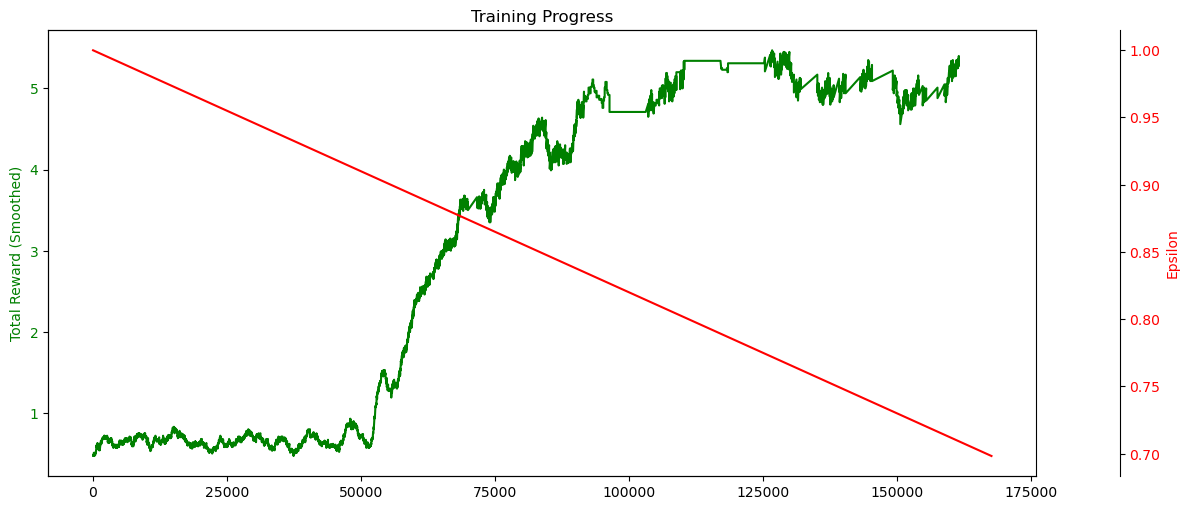

In [13]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Define the window size for moving average
window_size = 100

# Calculate the moving average for total rewards
smoothed_rewards = moving_average(plot_infos['total_reward'], window_size)

fig, ax1 = plt.subplots(figsize=(12, 5))

# Create a secondary y-axis for smoothed total rewards
ax1.plot(plot_infos['total_steps'][:len(smoothed_rewards)], smoothed_rewards, label='Total Reward (Smoothed)', color='green')
ax1.set_ylabel('Total Reward (Smoothed)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create another secondary y-axis for epsilon values
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))
ax2.plot(plot_infos['total_steps'], plot_infos['epsilon'], label='Epsilon', color='red')
ax2.set_ylabel('Epsilon', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title('Training Progress')
plt.show()

## Result
Here is the training playing each 50000 steps.

In [12]:
import glob
import torch
import os

# Path to checkpoints directory
CHECKPOINT_DIR = "checkpoints/upgraded"

# Function to load model weights from checkpoint file
def load_checkpoint(model, checkpoint_file):
    model.load_state_dict(torch.load(checkpoint_file))
    model.eval()  # Set the model to evaluation mode (important for inference)

# Function to play the game using the loaded model
def play_episode(env, model):
    obs = env.reset()
    state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # Initial state, [1, 4, 84, 84]
    total_reward = 0

    done = False
    max_ticks = 100
    while not done and max_ticks > 0:
        with torch.no_grad():
            action = model(state).argmax(dim=1).item()  # Select action with highest Q-value
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
        state = next_state
        total_reward += reward
        if done or truncated:
            break
        max_ticks -= 1

    return total_reward

# Iterate over each checkpoint file and run the evaluation
def evaluate_checkpoints(checkpoint_dir):
    # Glob all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.pth"))
    
    # Sort the checkpoint files if needed
    checkpoint_files.sort()

    # Create the environment
    env = make_env("ALE/Breakout-v5", render_mode=None, frame_skip=1)

    # Initialize DQN model (same as the one used during training)
    action_space = env.action_space.n
    model = NoisyDuelingDQN(action_space).to(device)  # Create the DQN model

    for checkpoint in checkpoint_files:
        print(f"Loading checkpoint: {checkpoint}")
        # Load the model weights from the checkpoint file
        load_checkpoint(model, checkpoint)

        # Play 50 episodes with the loaded model and calculate the average reward
        total_rewards = []
        for _ in range(50):
            total_reward = play_episode(env, model)
            total_rewards.append(total_reward)
        
        average_reward = sum(total_rewards) / len(total_rewards)
        print(f"Checkpoint {checkpoint}: Average Reward over 50 episodes = {average_reward}")

    env.close()

# Call the function to evaluate the checkpoints
evaluate_checkpoints(CHECKPOINT_DIR)

Loading checkpoint: checkpoints/upgraded/checkpoint_100000.pth


/var/folders/mv/3fqdyl697kg4mqs3tkmd7gs80000gn/T/ipykernel_40063/1871085291.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_

Checkpoint checkpoints/upgraded/checkpoint_100000.pth: Average Reward over 50 episodes = 0.22
Loading checkpoint: checkpoints/upgraded/checkpoint_150000.pth
Checkpoint checkpoints/upgraded/checkpoint_150000.pth: Average Reward over 50 episodes = 1.28
